Notes for myself:
- maybe add the upload_dt column when taking columns from item_daily_features to be able to apply a penalty on videos posted a while ago

# Imports

In [9]:
SEED = 69
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from typing import Tuple, Dict
import plotly.express as px
import plotly.figure_factory as ff
from scipy import stats
import ast
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Lambda
import tensorflow.keras.backend as K
#######################################
np.random.seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Loading the data

In [10]:
root = "data_final_project/KuaiRec 2.0/data/"
train_data = pd.read_parquet("./exports/train_data.pq")
test_data = pd.read_parquet("./exports/test_data.pq")

In [11]:
all_data_df = pd.concat([train_data, test_data], ignore_index=True)

# Data Analysis

### Analysis of Interaction Repartition

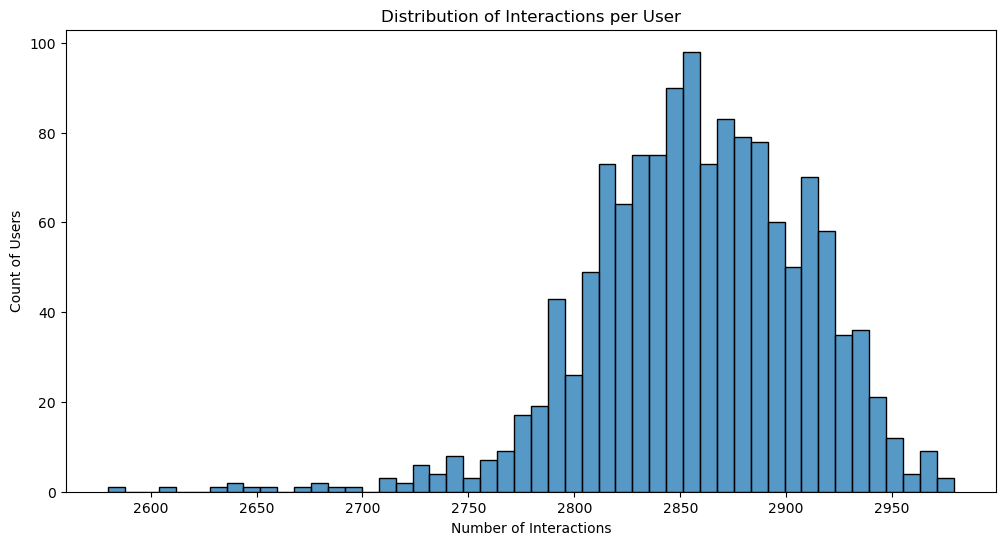

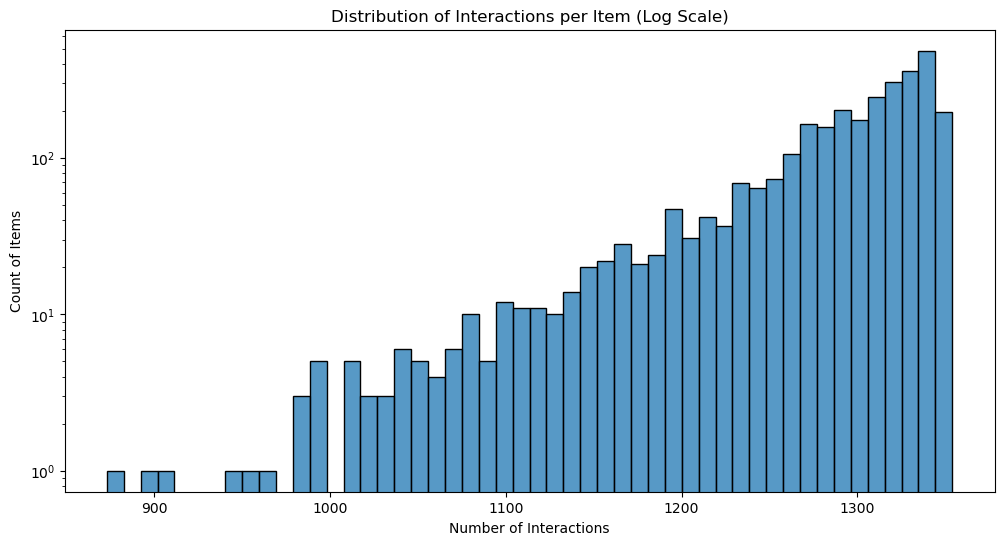

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(data=all_data_df["user_id"].value_counts(), bins=50, palette="icefire")
plt.title("Distribution of Interactions per User")
plt.xlabel("Number of Interactions")
plt.ylabel("Count of Users")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=all_data_df["video_id"].value_counts(), bins=50, log=True, palette="icefire")
plt.title("Distribution of Interactions per Item (Log Scale)")
plt.xlabel("Number of Interactions")
plt.ylabel("Count of Items")
plt.show()

### Analysis of Temporal Activity

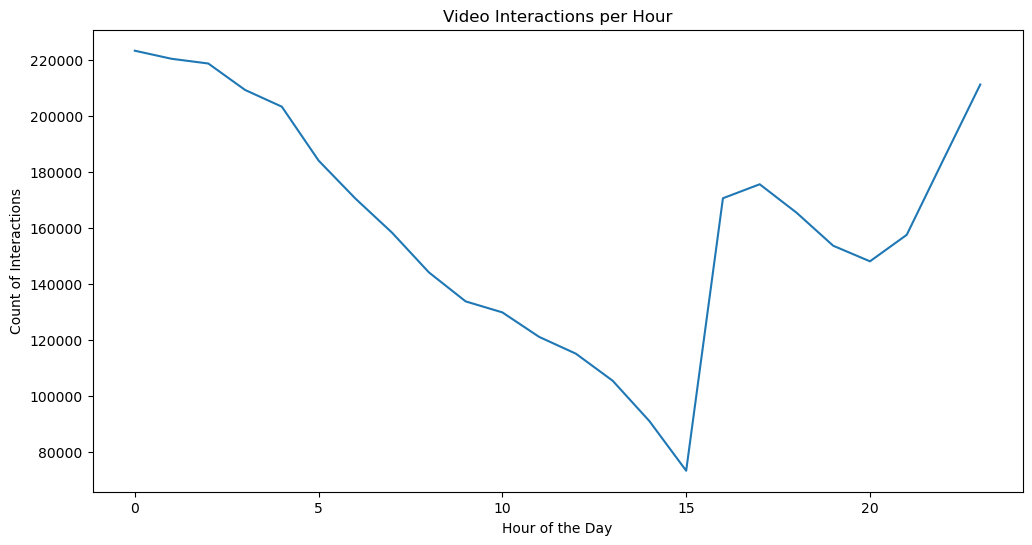

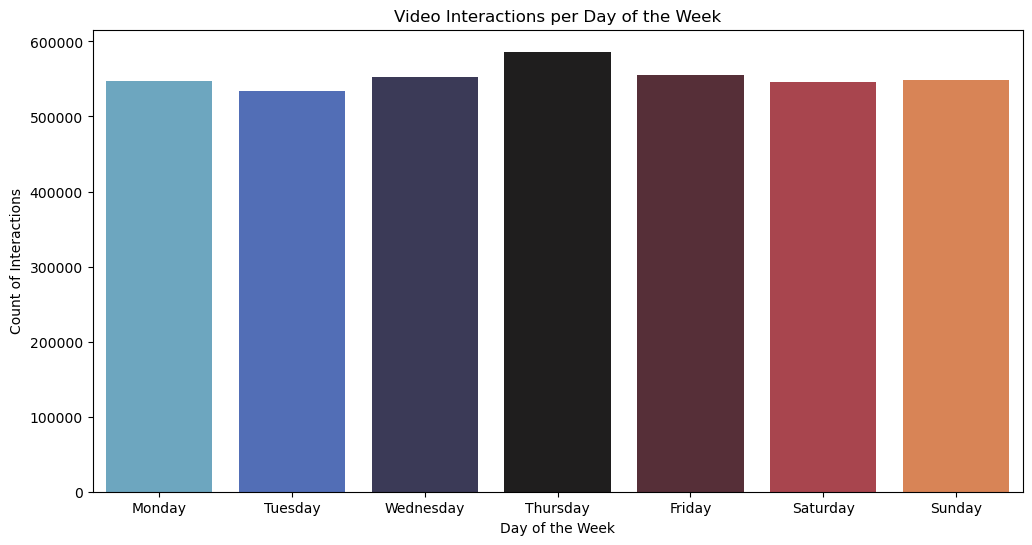

In [13]:
all_data_df["hour"] = all_data_df["timestamp"].dt.hour
all_data_df["weekday"] = all_data_df["timestamp"].dt.dayofweek

to_plot = all_data_df.groupby("hour").size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=to_plot.index, y=to_plot.values, palette="icefire")
plt.title("Video Interactions per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Count of Interactions")
plt.show()

to_plot = all_data_df.groupby("weekday").size()
plt.figure(figsize=(12, 6))
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.barplot(x=days, y=to_plot.values, palette="icefire")
plt.title("Video Interactions per Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Count of Interactions")
plt.show()

### Analysis of User Active Degree and Implications

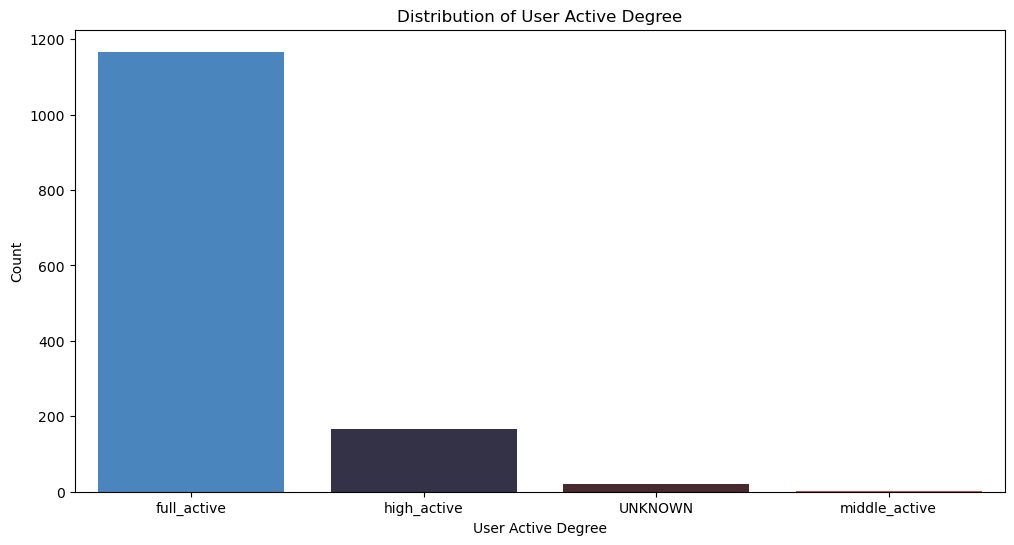

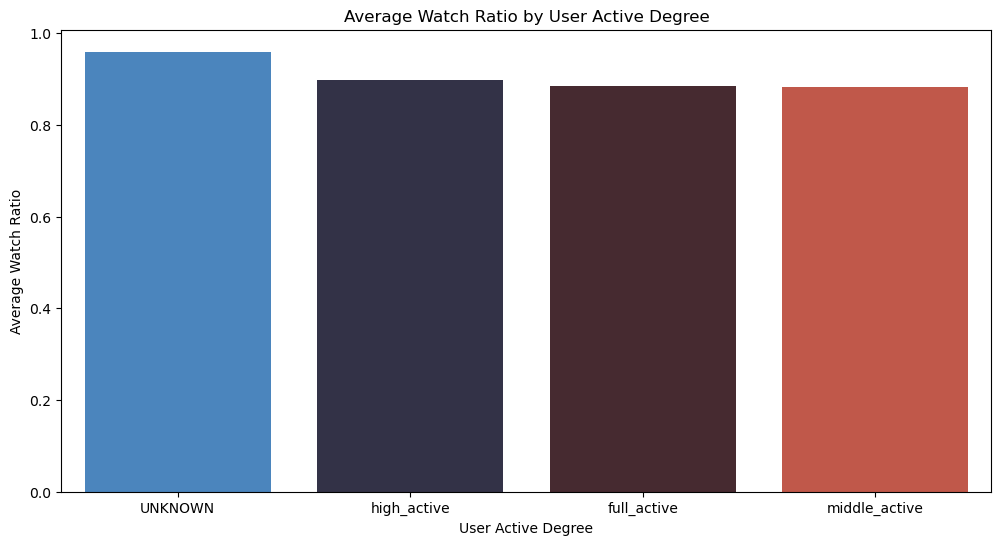

In [14]:
to_plot = all_data_df.groupby("user_active_degree")["user_id"].nunique().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=to_plot.index, y=to_plot.values, order=to_plot.index, palette="icefire")
plt.title("Distribution of User Active Degree")
plt.xlabel("User Active Degree")
plt.ylabel("Count")
plt.show()

to_plot = all_data_df.groupby("user_active_degree")["watch_ratio"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=to_plot.index, y=to_plot.values, order=to_plot.index, palette="icefire")
plt.title("Average Watch Ratio by User Active Degree")
plt.xlabel("User Active Degree")
plt.ylabel("Average Watch Ratio")
plt.show()

### Analysis of Video Categories

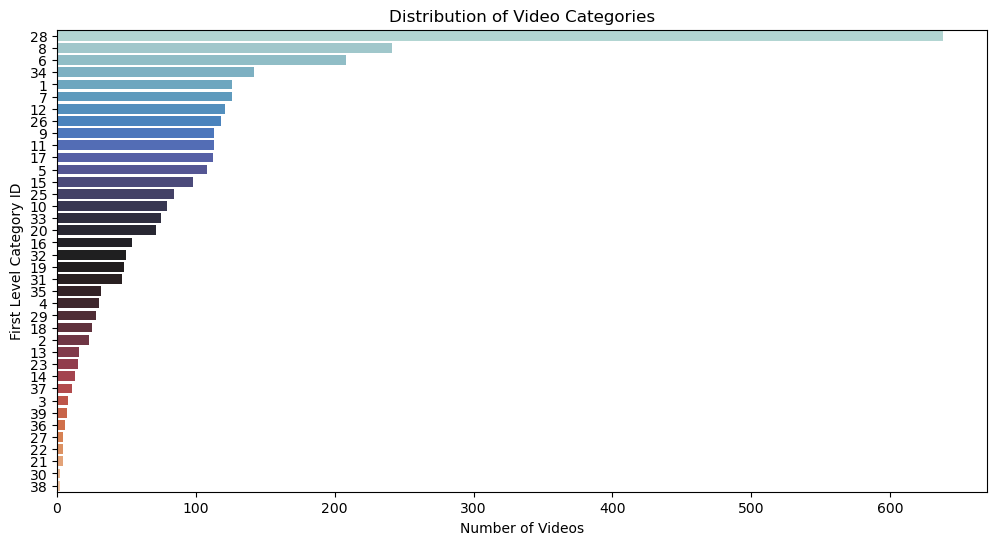

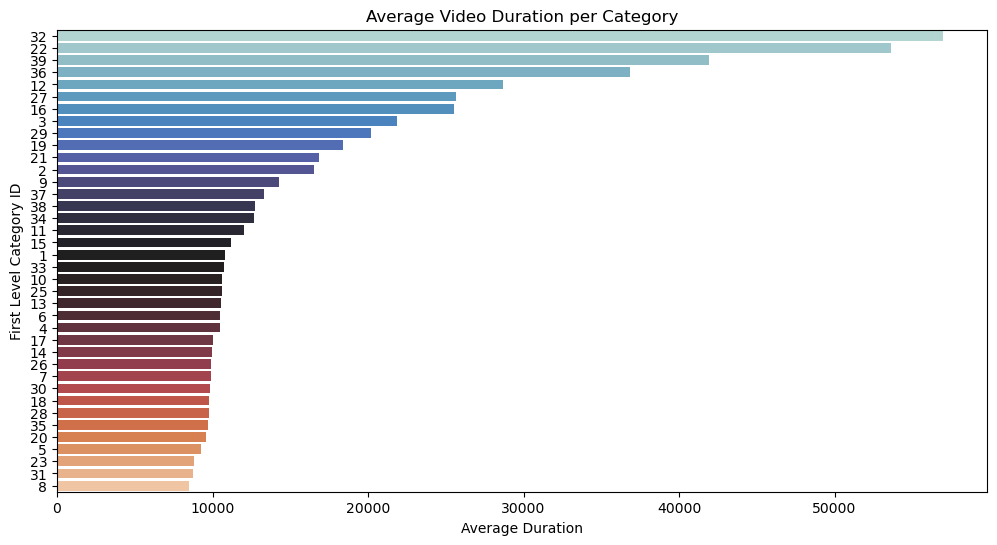

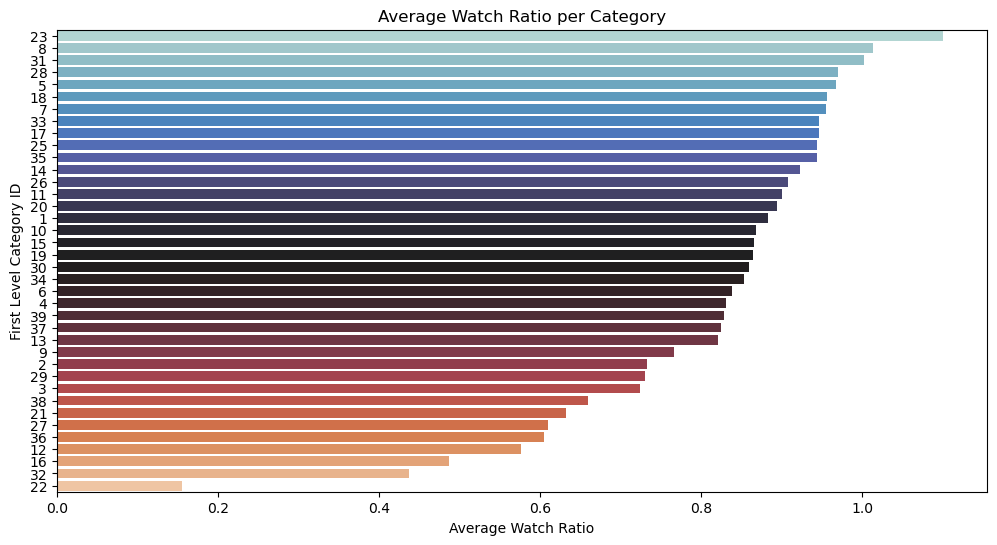

In [15]:
to_plot = all_data_df.drop_duplicates(subset="video_id")[["video_id", "first_level_category_id"]]
plt.figure(figsize=(12, 6))
sns.countplot(data=to_plot, y="first_level_category_id", order=to_plot["first_level_category_id"].value_counts().index, palette="icefire")
plt.title("Distribution of Video Categories")
plt.xlabel("Number of Videos")
plt.ylabel("First Level Category ID")
plt.show()

to_plot = all_data_df.drop_duplicates(subset="video_id").groupby("first_level_category_id")["video_duration"].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=to_plot, y="first_level_category_id", x="video_duration", orient="h", order=to_plot.sort_values("video_duration", ascending=False)["first_level_category_id"], palette="icefire")
plt.title("Average Video Duration per Category")
plt.xlabel("Average Duration")
plt.ylabel("First Level Category ID")
plt.show()

to_plot = all_data_df.groupby('first_level_category_id')['watch_ratio'].agg(['mean', 'count']).sort_values("mean", ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=to_plot, y="first_level_category_id", x="mean", orient="h", order=to_plot.index, palette="icefire")
plt.title("Average Watch Ratio per Category")
plt.xlabel("Average Watch Ratio")
plt.ylabel("First Level Category ID")
plt.show()

### Analysis on watch ratio

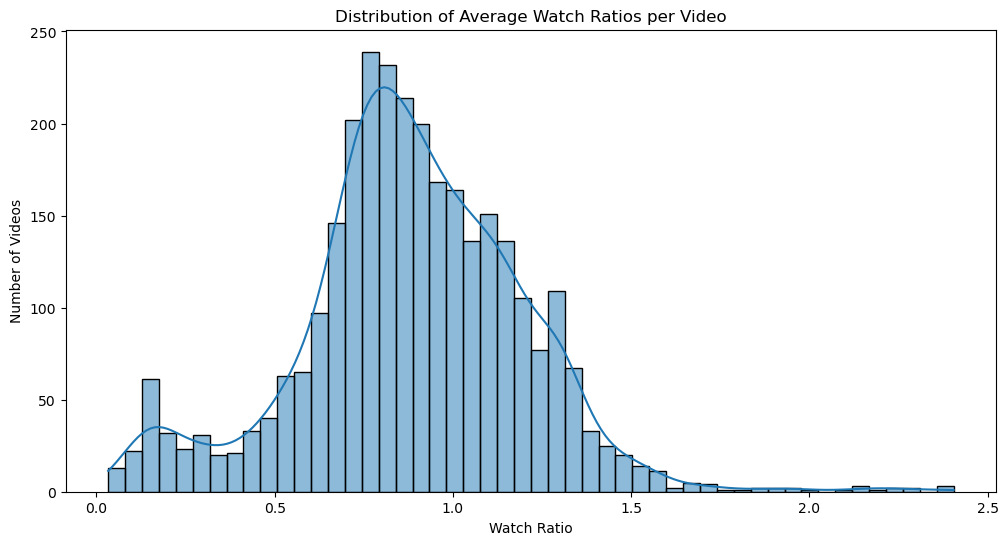

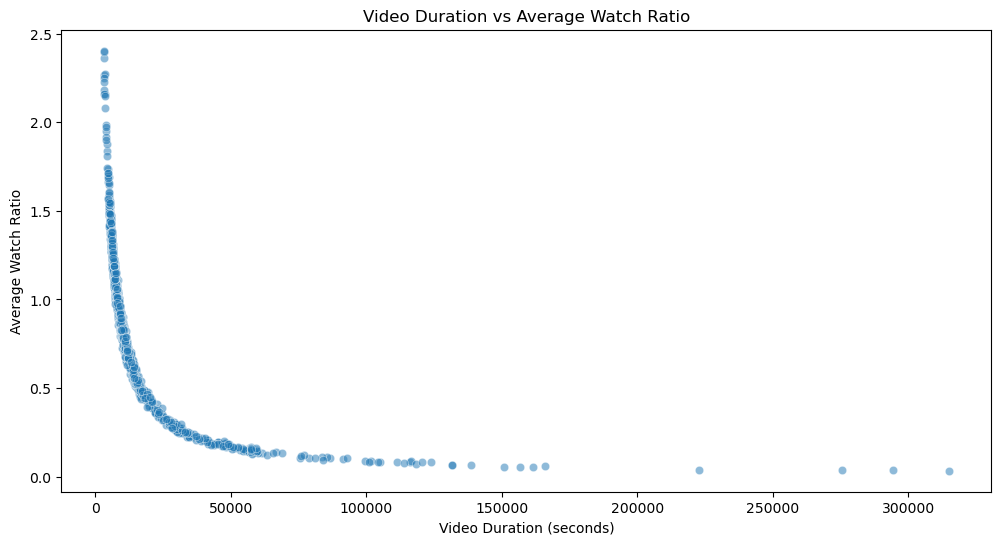

In [16]:
to_plot = all_data_df.groupby("video_id")["watch_ratio"].mean()
plt.figure(figsize=(12, 6))
sns.histplot(data=to_plot, bins=50, kde=True, palette="icefire")
plt.title("Distribution of Average Watch Ratios per Video")
plt.xlabel("Watch Ratio")
plt.ylabel("Number of Videos")
plt.show()

to_plot = all_data_df.groupby("video_id").agg({"video_duration": "first", "watch_ratio": "mean"}).reset_index()
plt.figure(figsize=(12, 6))
sns.scatterplot(data=to_plot, x="video_duration", y="watch_ratio", alpha=0.5, palette="icefire")
plt.title("Video Duration vs Average Watch Ratio")
plt.xlabel("Video Duration (seconds)")
plt.ylabel("Average Watch Ratio")
plt.show()